### Objetivo: modelo de previsão de vendas
##### Autor: Yan Sym

#### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from hyperopt import fmin, hp, tpe
from math import sqrt
import lightgbm as lgb
import warnings
import random
import gc

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
%matplotlib inline

#### Variáveis globais e parâmetros

In [2]:
random_seed = 42

#### Métodos

In [3]:
# métricas de erro
def mae_score(true, pred):
    return mean_absolute_error(true, pred)

def mse_score(true, pred):
    return mean_squared_error(true, pred)

def rmse_score(true, pred):
    return (sqrt(mean_squared_error(true, pred)))

#### Leitura de bases

In [4]:
df_lojas = pd.read_csv('lojas_atuais.csv')
print (df_lojas.shape)
df_lojas.head()

(3130, 21)


,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5300108005004,5300108,NaN,FEATURE_02_VALUE_03,True,22.00,FEATURE_05_VALUE_03,27,0.215967,0.197287,1562.674817,3.670883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3550308005052,3550308,NaN,FEATURE_02_VALUE_03,True,45.66,FEATURE_05_VALUE_03,6,0.190102,0.179140,5593.905463,2.815883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3145604003002,3145604,NaN,FEATURE_02_VALUE_04,False,30.00,FEATURE_05_VALUE_03,3,0.141988,0.143677,12.824022,7.218132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1600303005010,1600303,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,False,62.49,FEATURE_05_VALUE_03,30,0.107619,0.103083,325.531120,1.972944,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,100.0,88.1,100.0,100.0,88.5,93.8


#### engenharia de variáveis explicativas

In [5]:
df_lojas['feature_04_vezes_06'] = df_lojas['feature_04'] * df_lojas['feature_06']

In [6]:
df_faturamento = pd.read_csv('faturamento_lojas_atuais.csv')
print (df_faturamento.shape)
df_faturamento.head()

(1003094, 6)


,cod_loja,ano,mes,categoria,qtde,receita
0,1,2016,1,CATEG_01,301.0,9164.86
1,1,2016,2,CATEG_01,187.0,8175.55
2,1,2016,3,CATEG_01,242.0,10521.67
3,1,2016,4,CATEG_01,104.0,4560.91
4,1,2016,5,CATEG_01,100.0,4263.30


In [7]:
df_faturamento['cod_loja'].nunique()

3130

In [8]:
df_faturamento['categoria'].nunique()

16

In [9]:
df_faturamento['categoria'].unique().tolist()

['CATEG_01',
 'CATEG_02',
 'CATEG_03',
 'CATEG_04',
 'CATEG_05',
 'CATEG_06',
 'CATEG_07',
 'CATEG_08',
 'CATEG_09',
 'CATEG_10',
 'CATEG_11',
 'CATEG_12',
 'CATEG_13',
 'CATEG_14',
 'CATEG_15',
 'CATEG_16']

#### Análise por produto de cada loja

In [10]:
df_quantidade_anomes = pd.DataFrame(df_faturamento.groupby(['cod_loja', 'ano', 'mes']).\
                                    agg({'qtde': ['sum', 'mean', 'max', 'min']})).reset_index()

df_quantidade_anomes.columns = ['cod_loja', 'ano', 'mes', 'qtde_soma', 'qtde_media', 'qtde_min', 'qtde_max']

df_faturamento_medio_loja_anomes = pd.DataFrame(df_faturamento.groupby(['cod_loja', 'ano', 'mes'])['receita'].sum()).reset_index()
df_faturamento_medio_loja_anomes.columns = ['cod_loja', 'ano', 'mes', 'receita_total_loja_anomes']

df_faturamento = pd.merge(df_faturamento_medio_loja_anomes,
                          df_quantidade_anomes,
                          on=['cod_loja', 'ano', 'mes'],
                          how='inner')

In [11]:
df_faturamento['ano_mes'] = df_faturamento['ano'].map(str) + df_faturamento['mes'].map(str).str.zfill(2)
df_faturamento['ano_mes'] = pd.to_datetime(df_faturamento['ano_mes'], format='%Y%m')
df_faturamento['ano_mes'].value_counts(dropna=False)

2017-12-01    3123
2017-11-01    3108
2017-10-01    3100
2017-08-01    3093
2017-09-01    3092
2017-07-01    3091
2017-06-01    3088
2017-01-01    3087
2017-05-01    3087
2017-03-01    3084
2016-12-01    3083
2017-02-01    3083
2017-04-01    3078
2016-11-01    3064
2016-10-01    3049
2016-08-01    3048
2016-09-01    3048
2016-07-01    3046
2016-06-01    3041
2016-05-01    3036
2016-04-01    3031
2016-01-01    3029
2016-03-01    3028
2016-02-01    3027
Name: ano_mes, dtype: int64

In [12]:
df_faturamento['receita_m1'] = df_faturamento.groupby('cod_loja')['receita_total_loja_anomes'].transform(lambda x: x.shift(-1))
df_faturamento['receita_m2'] = df_faturamento.groupby('cod_loja')['receita_total_loja_anomes'].transform(lambda x: x.shift(-2))
df_faturamento['receita_m3'] = df_faturamento.groupby('cod_loja')['receita_total_loja_anomes'].transform(lambda x: x.shift(-3))
df_faturamento['receita_target'] = (df_faturamento['receita_m1'] + df_faturamento['receita_m2'] + df_faturamento['receita_m3'])/3

In [13]:
df_faturamento.head()

,cod_loja,ano,mes,receita_total_loja_anomes,qtde_soma,qtde_media,qtde_min,qtde_max,ano_mes,receita_m1,receita_m2,receita_m3,receita_target
0,1,2016,1,441833.37,13034.0,931.000000,3820.0,24.0,2016-01-01,395340.22,587810.18,534618.84,505923.080000
1,1,2016,2,395340.22,11411.0,815.071429,2637.0,24.0,2016-02-01,587810.18,534618.84,595477.92,572635.646667
2,1,2016,3,587810.18,15030.0,1073.571429,4251.0,71.0,2016-03-01,534618.84,595477.92,589947.05,573347.936667
3,1,2016,4,534618.84,12726.0,909.000000,3688.0,7.0,2016-04-01,595477.92,589947.05,563814.03,583079.666667
4,1,2016,5,595477.92,13978.0,998.428571,4345.0,84.0,2016-05-01,589947.05,563814.03,625181.36,592980.813333


In [14]:
df_media_movel1 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['qtde_soma'].transform(lambda x: x.rolling(3).mean()))

df_media_movel2 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_total_loja_anomes'].transform(lambda x: x.rolling(3).std()))

df_media_movel3 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_total_loja_anomes'].transform(lambda x: x.rolling(3).mean()))

df_media_movel4 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_total_loja_anomes'].transform(lambda x: x.shift(6)))

df_media_movel5 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_total_loja_anomes'].transform(lambda x: x.shift(12)))

df_media_movel6 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_target'].transform(lambda x: x.rolling(3).mean()))

df_media_movel7 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_target'].transform(lambda x: x.rolling(6).mean()))

df_media_movel8 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_target'].transform(lambda x: x.shift(12)))

df_media_movel9 = pd.DataFrame(df_faturamento.groupby(['cod_loja'])\
                              ['receita_target'].transform(lambda x: x.shift(1)))

df_faturamento['soma_quantidade_items_loja_media_movel_3_meses'] = df_media_movel1['qtde_soma'].values.tolist()
df_faturamento['receita_loja_std_3_meses'] = df_media_movel2['receita_total_loja_anomes'].values.tolist()
df_faturamento['receita_loja_media_movel_3_meses'] = df_media_movel3['receita_total_loja_anomes'].values.tolist()
df_faturamento['receita_loja_lag_6_meses'] = df_media_movel4['receita_total_loja_anomes'].values.tolist()
df_faturamento['receita_loja_lag_12_meses'] = df_media_movel5['receita_total_loja_anomes'].values.tolist()
df_faturamento['receita_target_media_movel_3_meses'] = df_media_movel6['receita_target'].values.tolist()
df_faturamento['receita_target_media_movel_6_meses'] = df_media_movel7['receita_target'].values.tolist()
df_faturamento['receita_target_lag_12_meses'] = df_media_movel8['receita_target'].values.tolist()
df_faturamento['receita_loja_lag_1'] = df_media_movel9['receita_target'].values.tolist()

df_faturamento.head(10)

,cod_loja,ano,mes,receita_total_loja_anomes,qtde_soma,qtde_media,qtde_min,qtde_max,ano_mes,receita_m1,receita_m2,receita_m3,receita_target,soma_quantidade_items_loja_media_movel_3_meses,receita_loja_std_3_meses,receita_loja_media_movel_3_meses,receita_loja_lag_6_meses,receita_loja_lag_12_meses,receita_target_media_movel_3_meses,receita_target_media_movel_6_meses,receita_target_lag_12_meses,receita_loja_lag_1
0,1,2016,1,441833.37,13034.0,931.000000,3820.0,24.0,2016-01-01,395340.22,587810.18,534618.84,505923.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,395340.22,11411.0,815.071429,2637.0,24.0,2016-02-01,587810.18,534618.84,595477.92,572635.646667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505923.080000
2,1,2016,3,587810.18,15030.0,1073.571429,4251.0,71.0,2016-03-01,534618.84,595477.92,589947.05,573347.936667,13158.333333,100428.687433,474994.590000,NaN,NaN,550635.554444,NaN,NaN,572635.646667
3,1,2016,4,534618.84,12726.0,909.000000,3688.0,7.0,2016-04-01,595477.92,589947.05,563814.03,583079.666667,13055.666667,99391.933058,505923.080000,NaN,NaN,576354.416667,NaN,NaN,573347.936667
4,1,2016,5,595477.92,13978.0,998.428571,4345.0,84.0,2016-05-01,589947.05,563814.03,625181.36,592980.813333,13911.333333,33145.991477,572635.646667,NaN,NaN,583136.138889,NaN,NaN,583079.666667
5,1,2016,6,589947.05,14693.0,1049.500000,3894.0,95.0,2016-06-01,563814.03,625181.36,583509.12,590834.836667,13799.000000,33654.194794,573347.936667,NaN,NaN,588965.105556,569800.330000,NaN,592980.813333
6,1,2016,7,563814.03,13570.0,969.285714,3437.0,90.0,2016-07-01,625181.36,583509.12,611797.30,606829.260000,14080.333333,16912.161242,583079.666667,441833.37,NaN,596881.636667,586618.026667,NaN,590834.836667
7,1,2016,8,625181.36,13889.0,992.071429,4159.0,81.0,2016-08-01,583509.12,611797.30,876921.63,690742.683333,14050.666667,30795.942717,592980.813333,395340.22,NaN,629468.926667,606302.532778,NaN,606829.260000
8,1,2016,9,583509.12,13309.0,950.642857,3924.0,90.0,2016-09-01,611797.30,876921.63,1257613.00,915443.976667,13589.333333,31332.680883,590834.836667,587810.18,NaN,737671.973333,663318.539444,NaN,690742.683333
9,1,2016,10,611797.30,14709.0,1131.461538,3907.0,79.0,2016-10-01,876921.63,1257613.00,404108.77,846214.466667,13969.000000,21275.689477,606829.260000,534618.84,NaN,817467.042222,707174.339444,NaN,915443.976667


In [15]:
df_faturamento.shape

(73644, 22)

In [16]:
df_faturamento.head(100)

,cod_loja,ano,mes,receita_total_loja_anomes,qtde_soma,qtde_media,qtde_min,qtde_max,ano_mes,receita_m1,receita_m2,receita_m3,receita_target,soma_quantidade_items_loja_media_movel_3_meses,receita_loja_std_3_meses,receita_loja_media_movel_3_meses,receita_loja_lag_6_meses,receita_loja_lag_12_meses,receita_target_media_movel_3_meses,receita_target_media_movel_6_meses,receita_target_lag_12_meses,receita_loja_lag_1
0,1,2016,1,441833.37,13034.0,931.000000,3820.0,24.0,2016-01-01,395340.22,587810.18,534618.84,505923.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,395340.22,11411.0,815.071429,2637.0,24.0,2016-02-01,587810.18,534618.84,595477.92,572635.646667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505923.080000
2,1,2016,3,587810.18,15030.0,1073.571429,4251.0,71.0,2016-03-01,534618.84,595477.92,589947.05,573347.936667,13158.333333,100428.687433,474994.590000,NaN,NaN,550635.554444,NaN,NaN,572635.646667
3,1,2016,4,534618.84,12726.0,909.000000,3688.0,7.0,2016-04-01,595477.92,589947.05,563814.03,583079.666667,13055.666667,99391.933058,505923.080000,NaN,NaN,576354.416667,NaN,NaN,573347.936667
4,1,2016,5,595477.92,13978.0,998.428571,4345.0,84.0,2016-05-01,589947.05,563814.03,625181.36,592980.813333,13911.333333,33145.991477,572635.646667,NaN,NaN,583136.138889,NaN,NaN,583079.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,2017,12,173683.70,4148.0,319.076923,947.0,13.0,2017-12-01,NaN,NaN,NaN,NaN,2380.333333,68932.752823,94818.060000,59034.85,168548.71,NaN,NaN,47384.846667,NaN
96,5,2016,1,248834.01,5800.0,414.285714,2040.0,7.0,2016-01-01,182297.02,210579.83,202545.65,198474.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,5,2016,2,182297.02,3896.0,278.285714,1059.0,13.0,2016-02-01,210579.83,202545.65,343893.54,252339.673333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198474.166667
98,5,2016,3,210579.83,3920.0,280.000000,1287.0,4.0,2016-03-01,202545.65,343893.54,256717.01,267718.733333,4538.666667,33392.790308,213903.620000,NaN,NaN,239510.857778,NaN,NaN,252339.673333


In [17]:
df_faturamento.loc[(df_faturamento['receita_target'].isnull()) & (df_faturamento['ano_mes'] <= '2017-06-01')]

,cod_loja,ano,mes,receita_total_loja_anomes,qtde_soma,qtde_media,qtde_min,qtde_max,ano_mes,receita_m1,receita_m2,receita_m3,receita_target,soma_quantidade_items_loja_media_movel_3_meses,receita_loja_std_3_meses,receita_loja_media_movel_3_meses,receita_loja_lag_6_meses,receita_loja_lag_12_meses,receita_target_media_movel_3_meses,receita_target_media_movel_6_meses,receita_target_lag_12_meses,receita_loja_lag_1
29862,1456,2017,5,226281.63,5008.0,385.230769,1163.0,7.0,2017-05-01,113736.80,206277.76,NaN,NaN,4112.333333,52487.922739,165716.343333,159747.37,215107.33,NaN,NaN,154588.836667,182098.730000
48683,2393,2017,3,67995.07,1927.0,137.642857,533.0,1.0,2017-03-01,44922.34,107451.14,NaN,NaN,1666.333333,6719.859408,63315.283333,70496.25,65195.92,NaN,NaN,72845.490000,73456.183333
66441,3275,2017,3,16317.19,515.0,39.615385,227.0,1.0,2017-03-01,16238.59,31449.19,NaN,NaN,274.666667,7949.983675,10739.806667,NaN,NaN,NaN,NaN,NaN,21334.990000
66442,3275,2017,4,16238.59,666.0,55.500000,371.0,1.0,2017-04-01,31449.19,NaN,NaN,NaN,485.666667,1162.501074,15607.103333,NaN,NaN,NaN,NaN,NaN,NaN
66443,3275,2017,5,31449.19,659.0,47.071429,182.0,1.0,2017-05-01,NaN,NaN,NaN,NaN,613.333333,8759.242303,21334.990000,NaN,NaN,NaN,NaN,NaN,NaN
69627,3459,2017,2,9672.27,216.0,18.000000,53.0,1.0,2017-02-01,4307.34,35331.13,NaN,NaN,713.000000,35897.869673,43086.203333,99275.93,46283.91,NaN,NaN,62539.936667,16436.913333
69628,3459,2017,3,4307.34,102.0,10.200000,43.0,2.0,2017-03-01,35331.13,NaN,NaN,NaN,312.333333,18417.456819,17509.740000,90214.65,53929.81,NaN,NaN,62630.676667,NaN
69645,3460,2017,4,674.40,16.0,2.666667,6.0,1.0,2017-04-01,117.60,60096.08,NaN,NaN,104.000000,4468.664946,5834.363333,175808.82,97860.29,NaN,NaN,75652.916667,20296.026667
69646,3460,2017,5,117.60,4.0,2.000000,3.0,1.0,2017-05-01,60096.08,NaN,NaN,NaN,61.333333,4641.840381,3071.143333,180882.18,119647.95,NaN,NaN,105744.556667,NaN
71104,3550,2016,12,167726.99,3125.0,240.384615,756.0,12.0,2016-12-01,2385.46,38768.80,NaN,NaN,2624.333333,33542.848291,133963.150000,115407.31,NaN,NaN,NaN,NaN,69627.083333


In [18]:
df_faturamento = df_faturamento.loc[(~df_faturamento['receita_target'].isnull())]

In [19]:
df_faturamento.shape

(64283, 22)

In [20]:
df_faturamento['ano_mes'].unique()

array(['2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### junta variáveis explicativas

In [21]:
df_faturamento = pd.merge(df_faturamento,
                          df_lojas,
                          on='cod_loja',
                          how='left')

In [22]:
df_faturamento.shape

(64283, 43)

In [23]:
df_faturamento.head()

,cod_loja,ano,mes,receita_total_loja_anomes,qtde_soma,qtde_media,qtde_min,qtde_max,ano_mes,receita_m1,receita_m2,receita_m3,receita_target,soma_quantidade_items_loja_media_movel_3_meses,receita_loja_std_3_meses,receita_loja_media_movel_3_meses,receita_loja_lag_6_meses,receita_loja_lag_12_meses,receita_target_media_movel_3_meses,receita_target_media_movel_6_meses,receita_target_lag_12_meses,receita_loja_lag_1,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_04_vezes_06
0,1,2016,1,441833.37,13034.0,931.000000,3820.0,24.0,2016-01-01,395340.22,587810.18,534618.84,505923.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56
1,1,2016,2,395340.22,11411.0,815.071429,2637.0,24.0,2016-02-01,587810.18,534618.84,595477.92,572635.646667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505923.080000,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56
2,1,2016,3,587810.18,15030.0,1073.571429,4251.0,71.0,2016-03-01,534618.84,595477.92,589947.05,573347.936667,13158.333333,100428.687433,474994.590000,NaN,NaN,550635.554444,NaN,NaN,572635.646667,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56
3,1,2016,4,534618.84,12726.0,909.000000,3688.0,7.0,2016-04-01,595477.92,589947.05,563814.03,583079.666667,13055.666667,99391.933058,505923.080000,NaN,NaN,576354.416667,NaN,NaN,573347.936667,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56
4,1,2016,5,595477.92,13978.0,998.428571,4345.0,84.0,2016-05-01,589947.05,563814.03,625181.36,592980.813333,13911.333333,33145.991477,572635.646667,NaN,NaN,583136.138889,NaN,NaN,583079.666667,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56


In [24]:
df_faturamento['random_var'] = [np.random.normal() for i in range(len(df_faturamento))]

#### separa base em treino e teste

In [25]:
df_train = df_faturamento.loc[df_faturamento['ano_mes'] <= '2017-06-01']
df_test = df_faturamento.loc[df_faturamento['ano_mes'] >= '2017-07-01']

In [26]:
df_train.shape

(55024, 44)

In [27]:
df_test.shape

(9259, 44)

In [28]:
df_train['ano_mes'].unique()

array(['2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [29]:
df_test['ano_mes'].unique()

array(['2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Desenvolvimento do modelo

In [30]:
lista_vars_explicativas = ['cod_municipio',
'mes',
'qtde_media',
'qtde_soma',
'qtde_max',
'qtde_min',
'receita_target_lag_12_meses',
'receita_loja_std_3_meses',
'feature_04',
'feature_08',
'feature_09',
'feature_14',
'feature_18',
'feature_04_vezes_06',
'receita_target_media_movel_3_meses',
'receita_total_loja_anomes',
'receita_loja_media_movel_3_meses',
'soma_quantidade_items_loja_media_movel_3_meses',
'receita_loja_lag_1']

In [31]:
len(lista_vars_explicativas)

19

### Correlações

In [32]:
df_check = df_train[lista_vars_explicativas + ['receita_target']].copy()
df_check[df_check.columns].corr()['receita_target'][:].sort_values(ascending=False)

receita_target                                    1.000000
receita_target_lag_12_meses                       0.984956
receita_target_media_movel_3_meses                0.975507
receita_loja_lag_1                                0.961597
soma_quantidade_items_loja_media_movel_3_meses    0.876286
receita_loja_media_movel_3_meses                  0.875840
qtde_soma                                         0.808494
qtde_media                                        0.808369
receita_total_loja_anomes                         0.802155
qtde_min                                          0.797168
feature_04_vezes_06                               0.693810
feature_04                                        0.645148
qtde_max                                          0.405829
receita_loja_std_3_meses                          0.402657
feature_09                                        0.236743
feature_18                                        0.143391
feature_14                                        0.0993

### Divide dados em variáveis explicativas e target

In [33]:
X_train = df_train[lista_vars_explicativas].copy()
y_train = df_train[['receita_target']].copy()

X_test = df_test[lista_vars_explicativas].copy()
y_test = df_test[['receita_target']].copy()

print (f'X_train: {X_train.shape}')
print (f'y_train: {y_train.shape}')
print (f'X_test: {X_test.shape}')
print (f'y_test: {y_test.shape}')

X_train: (55024, 19)
y_train: (55024, 1)
X_test: (9259, 19)
y_test: (9259, 1)


In [34]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds

TimeSeriesSplit(max_train_size=None, n_splits=5)

In [35]:
len(lista_vars_explicativas)

19

In [36]:
X_train[lista_vars_explicativas].shape

(55024, 19)

In [37]:
X_train[lista_vars_explicativas]

,cod_municipio,mes,qtde_media,qtde_soma,qtde_max,qtde_min,receita_target_lag_12_meses,receita_loja_std_3_meses,feature_04,feature_08,feature_09,feature_14,feature_18,feature_04_vezes_06,receita_target_media_movel_3_meses,receita_total_loja_anomes,receita_loja_media_movel_3_meses,soma_quantidade_items_loja_media_movel_3_meses,receita_loja_lag_1
0,4125506,1,931.000000,13034.0,24.0,3820.0,NaN,NaN,21.76,0.167659,115.958848,NaN,NaN,674.56,NaN,441833.37,NaN,NaN,NaN
1,4125506,2,815.071429,11411.0,24.0,2637.0,NaN,NaN,21.76,0.167659,115.958848,NaN,NaN,674.56,NaN,395340.22,NaN,NaN,505923.080000
2,4125506,3,1073.571429,15030.0,71.0,4251.0,NaN,100428.687433,21.76,0.167659,115.958848,NaN,NaN,674.56,550635.554444,587810.18,474994.590000,13158.333333,572635.646667
3,4125506,4,909.000000,12726.0,7.0,3688.0,NaN,99391.933058,21.76,0.167659,115.958848,NaN,NaN,674.56,576354.416667,534618.84,505923.080000,13055.666667,573347.936667
4,4125506,5,998.428571,13978.0,84.0,4345.0,NaN,33145.991477,21.76,0.167659,115.958848,NaN,NaN,674.56,583136.138889,595477.92,572635.646667,13911.333333,583079.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64275,4211702,2,82.357143,1153.0,2.0,248.0,60319.050000,76820.782591,26.50,0.193531,7.701540,NaN,NaN,53.00,56362.401111,39229.17,88506.933333,2203.666667,53331.930000
64276,4211702,3,127.785714,1789.0,3.0,370.0,62574.716667,12126.814589,26.50,0.193531,7.701540,NaN,NaN,53.00,61180.758889,63369.27,50622.580000,1419.666667,65132.693333
64277,4211702,4,98.928571,1385.0,1.0,258.0,61929.120000,12573.059963,26.50,0.193531,7.701540,NaN,NaN,53.00,64036.867778,57397.35,53331.930000,1442.333333,65077.653333
64278,4211702,5,115.000000,1610.0,2.0,319.0,57114.906667,8751.336084,26.50,0.193531,7.701540,NaN,NaN,53.00,62574.946667,74631.46,65132.693333,1594.666667,61900.256667


In [38]:
params = {'num_leaves': 8,
          'learning_rate': 0.05,
          'subsample': 0.85,
          'feature_fraction': 0.85,
          'boosting_type': 'gbdt',
          'n_jobs': 3,
          'max_depth': -1,
          "metric": 'rmse',
          'random_state': 42,
          'reg_lambda': 10}

splits = folds.split(X_train, y_train)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
columns = X_train.columns.tolist()

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train_tmp, X_valid_tmp = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_train_tmp, y_valid_tmp = y_train.iloc[train_index], y_train.iloc[valid_index]
    dtrain = lgb.Dataset(X_train_tmp, label=y_train_tmp)
    dvalid = lgb.Dataset(X_valid_tmp, label=y_valid_tmp)
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], early_stopping_rounds=50, verbose_eval=1000)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid_tmp,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid_tmp))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(X_test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train_tmp, X_valid_tmp, y_train_tmp, y_valid_tmp
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
df_test['pred'] = y_preds

print ('Valor estimado:', y_preds.sum())
print ('Valor realizado:', y_test.sum())
print ('MAE:', mae_score(y_test, y_preds))
print ('MSE:', mse_score(y_test, y_preds))
print ('RMSE:', rmse_score(y_test, y_preds))

Fold: 1
Training until validation scores don't improve for 50 rounds
[1000]	training's rmse: 6364.29	valid_1's rmse: 9478.81
Early stopping, best iteration is:
[1818]	training's rmse: 5172.86	valid_1's rmse: 9142.81
val rmse score is 9142.809695880016
Fold: 2
Training until validation scores don't improve for 50 rounds
[1000]	training's rmse: 6481.95	valid_1's rmse: 8129.04
[2000]	training's rmse: 5359.31	valid_1's rmse: 7631.2
[3000]	training's rmse: 4680.86	valid_1's rmse: 7416.15
[4000]	training's rmse: 4226.28	valid_1's rmse: 7287.26
[5000]	training's rmse: 3859.24	valid_1's rmse: 7214.49
Early stopping, best iteration is:
[5468]	training's rmse: 3706.3	valid_1's rmse: 7198.72
val rmse score is 7198.7176497359815
Fold: 3
Training until validation scores don't improve for 50 rounds
[1000]	training's rmse: 6494.43	valid_1's rmse: 8790.34
[2000]	training's rmse: 5468.49	valid_1's rmse: 8351
[3000]	training's rmse: 4871.61	valid_1's rmse: 8192.54
Early stopping, best iteration is:
[333

<ipython-input-38-15e043ae0dcd>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = y_preds


#### Importância das variáveis explicativas do último fold

In [39]:
feature_importances

,feature,fold_1,fold_2,fold_3,fold_4,fold_5
0,cod_municipio,506,1836,1098,389,475
1,mes,1729,4534,3197,1645,1857
2,qtde_media,531,1054,591,216,222
3,qtde_soma,462,1233,788,255,333
4,qtde_max,363,1120,548,221,209
5,qtde_min,702,2081,1074,399,458
6,receita_target_lag_12_meses,273,960,544,252,264
7,receita_loja_std_3_meses,796,2494,1559,671,751
8,feature_04,406,1175,579,323,290
9,feature_08,256,870,466,139,173


In [40]:
i = 1
for a,b in sorted(list(zip(clf.feature_importance(), X_train.columns))):
    print (i, a, b, sep=' ')
    i+=1

1 159 feature_14
2 173 feature_08
3 209 qtde_max
4 222 qtde_media
5 227 feature_18
6 264 receita_target_lag_12_meses
7 274 soma_quantidade_items_loja_media_movel_3_meses
8 290 feature_04
9 314 feature_09
10 333 qtde_soma
11 418 feature_04_vezes_06
12 458 qtde_min
13 462 receita_loja_media_movel_3_meses
14 475 cod_municipio
15 751 receita_loja_std_3_meses
16 1072 receita_total_loja_anomes
17 1129 receita_loja_lag_1
18 1791 receita_target_media_movel_3_meses
19 1857 mes


In [41]:
i = 1
for a,b in sorted(list(zip(clf.feature_importance(), X_train.columns))):
    if (a > 0):
        print (b)
        i+1

feature_14
feature_08
qtde_max
qtde_media
feature_18
receita_target_lag_12_meses
soma_quantidade_items_loja_media_movel_3_meses
feature_04
feature_09
qtde_soma
feature_04_vezes_06
qtde_min
receita_loja_media_movel_3_meses
cod_municipio
receita_loja_std_3_meses
receita_total_loja_anomes
receita_loja_lag_1
receita_target_media_movel_3_meses
mes


#### erro de treino

In [42]:
df_preds = df_train.copy()
y_pred = clf.predict(X_train)
df_preds['true'] = y_train
df_preds['pred'] = y_pred
df_resultados = df_preds[['true', 'pred']].copy()
erro = rmse_score(df_preds['true'], df_preds['pred'])
print ('Erro de treino:', erro)

Erro de treino: 8109.348090175121


#### erro de teste

In [43]:
df_preds = df_test.copy()
y_pred = clf.predict(X_test)
df_preds['true'] = y_test
df_preds['pred'] = y_pred
df_resultados = df_preds[['true', 'pred']].copy()
erro = rmse_score(df_preds['true'], df_preds['pred'])
print ('Erro de teste:', erro)

Erro de teste: 9131.143155800819


In [44]:
df_preds['pred']

18       691709.126675
19       718820.376724
20       899566.805553
39        66101.328008
40        65778.055308
             ...      
64260     96302.094581
64261    146500.907064
64280     57490.454955
64281     58192.796261
64282     96537.105318
Name: pred, Length: 9259, dtype: float64

In [45]:
df_preds.shape

(9259, 46)

In [46]:
y_test.shape

(9259, 1)

In [47]:
df_preds.head()

,cod_loja,ano,mes,receita_total_loja_anomes,qtde_soma,qtde_media,qtde_min,qtde_max,ano_mes,receita_m1,receita_m2,receita_m3,receita_target,soma_quantidade_items_loja_media_movel_3_meses,receita_loja_std_3_meses,receita_loja_media_movel_3_meses,receita_loja_lag_6_meses,receita_loja_lag_12_meses,receita_target_media_movel_3_meses,receita_target_media_movel_6_meses,receita_target_lag_12_meses,receita_loja_lag_1,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_04_vezes_06,random_var,pred,true
18,1,2017,7,646369.23,13704.0,978.857143,4099.0,1.0,2017-07-01,757850.68,602313.53,637339.76,665834.656667,14358.000000,50985.549905,698321.286667,404108.77,563814.03,678729.996667,680601.512778,606829.260000,668844.480000,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56,-1.500822,691709.126675,665834.656667
19,1,2017,8,757850.68,15884.0,1221.846154,4311.0,15.0,2017-08-01,602313.53,637339.76,891173.22,710275.503333,14624.666667,55750.382886,701510.853333,483610.18,625181.36,681651.546667,688612.087222,690742.683333,665834.656667,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56,1.205242,718820.376724,710275.503333
20,1,2017,9,602313.53,13637.0,1049.000000,3581.0,14.0,2017-09-01,637339.76,891173.22,1216996.84,915169.940000,14408.333333,80167.349367,668844.480000,626291.59,583509.12,763760.033333,726659.453333,915443.976667,710275.503333,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.56,-0.113754,899566.805553,915169.940000
39,2,2017,7,60697.95,1355.0,96.785714,394.0,2.0,2017-07-01,72463.56,64936.11,59996.08,65798.583333,1545.666667,13044.712965,74472.400000,55235.99,69741.67,67192.885556,69213.637778,58585.990000,66032.540000,5300108005004,5300108,NaN,FEATURE_02_VALUE_03,True,22.00,FEATURE_05_VALUE_03,27,0.215967,0.197287,1562.674817,3.670883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.00,-0.989946,66101.328008,65798.583333
40,2,2017,8,72463.56,1774.0,126.714286,415.0,1.0,2017-08-01,64936.11,59996.08,76670.53,67200.906667,1577.666667,8043.186539,69747.533333,39019.13,65833.00,66344.010000,69189.961667,54585.036667,65798.583333,5300108005004,5300108,NaN,FEATURE_02_VALUE_03,True,22.00,FEATURE_05_VALUE_03,27,0.215967,0.197287,1562.674817,3.670883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.00,0.397337,65778.055308,67200.906667


#### Avaliação dos resultados

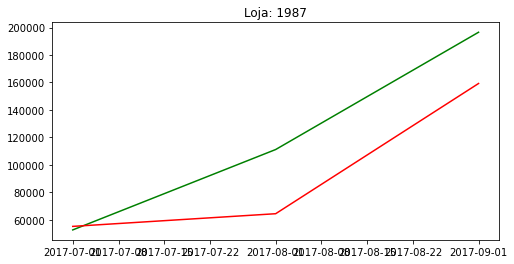

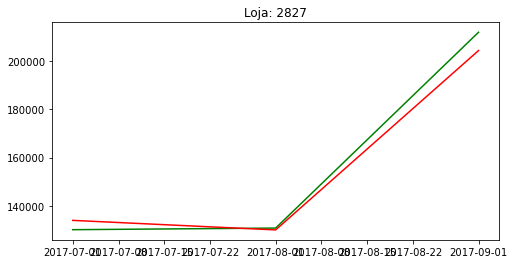

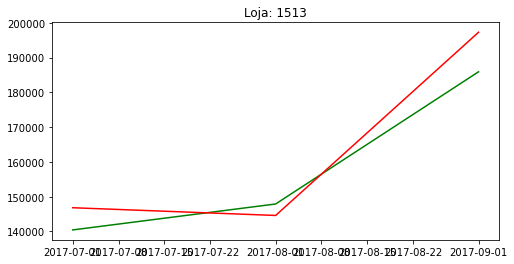

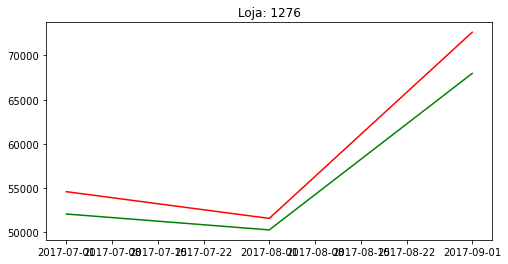

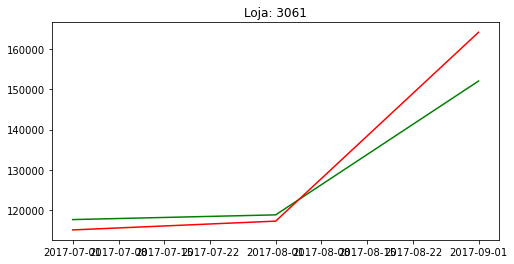

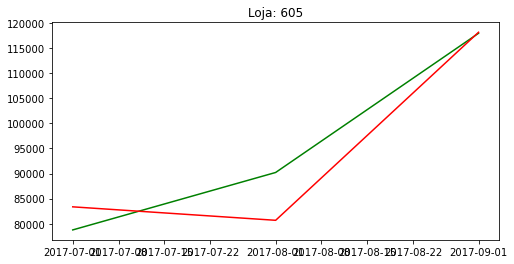

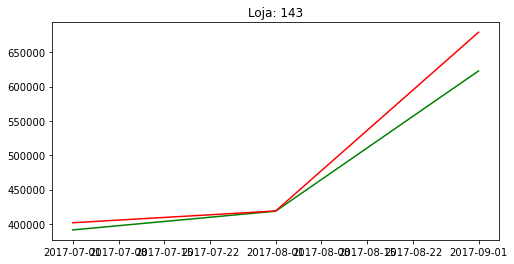

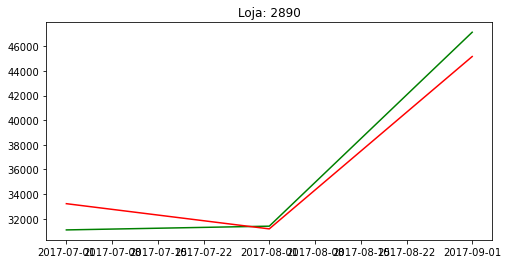

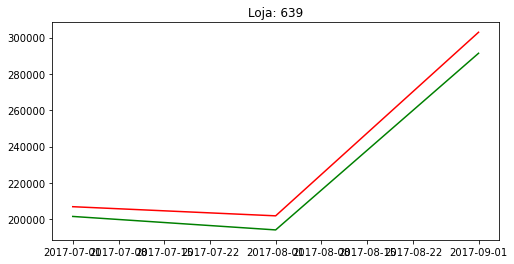

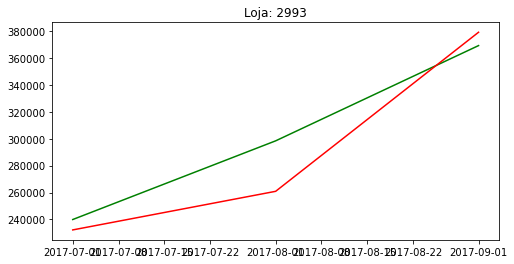

In [48]:
i = 0
while (i < 10):
    cod_loja = random.choice(df_preds['cod_loja'].unique())
    data_plot = df_preds.loc[df_preds['cod_loja'] == cod_loja]
    if (len(data_plot) > 0):
        plt.figure(figsize=(8,4))
        plt.plot(data_plot['ano_mes'], data_plot['true'], color='green', label='True')
        plt.plot(data_plot['ano_mes'], data_plot['pred'], color='red', label='Pred')
        plt.title(f'Loja: {cod_loja}')
        plt.show()
        i+=1

In [49]:
df_preds = df_test.copy()
y_pred = clf.predict(X_test)
df_preds['true'] = y_test
df_preds['pred'] = y_pred
df_resultados = df_preds[['true', 'pred']].copy()
erro = rmse_score(df_preds['true'], df_preds['pred'])
print ('Erro de teste:', erro)

Erro de teste: 9131.143155800819


In [50]:
df_preds['ano_mes'].unique()

array(['2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000'], dtype='datetime64[ns]')

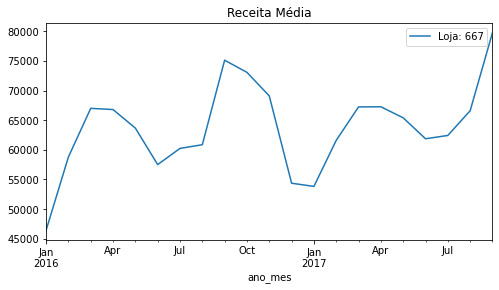

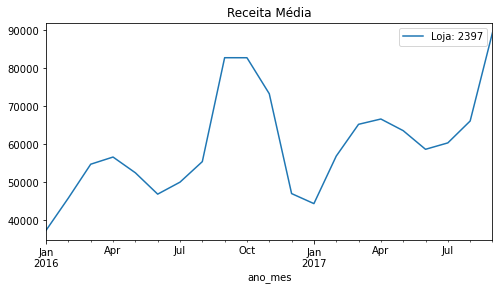

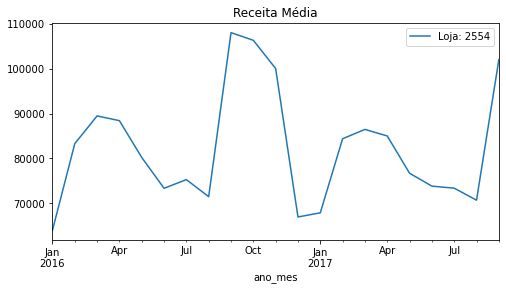

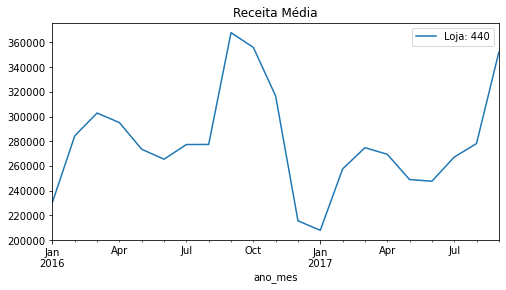

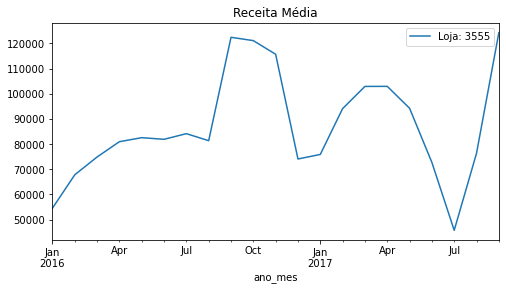

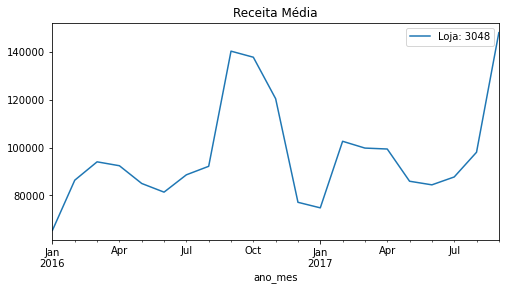

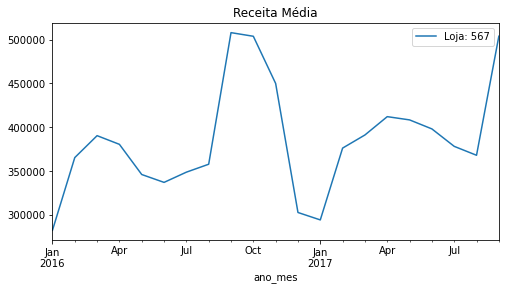

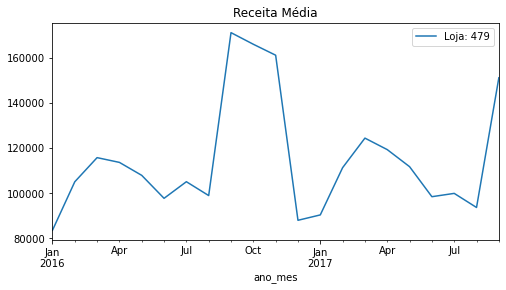

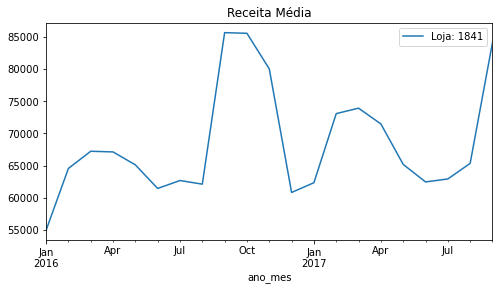

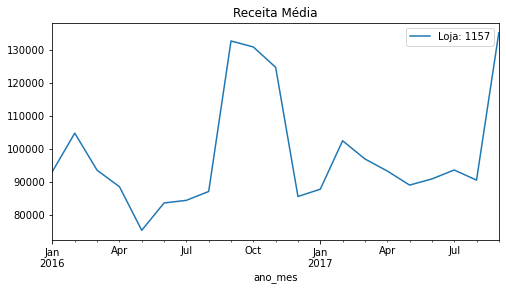

In [51]:
df_faturamento['cod_tmp'] = df_faturamento['cod_loja'].astype(int)
               
i = 0
while (i < 10):
    cod_loja = np.random.randint(1, df_faturamento.cod_tmp.max() + 1)
    data_plot = df_faturamento.loc[df_faturamento['cod_tmp'] == cod_loja]
    if (len(data_plot) > 0):
        data_plot.plot(x='ano_mes', y='receita_target',
                       label = f"Loja: {cod_loja}",
                       figsize = (8,4),
                       title = "Receita Média");
        i+=1

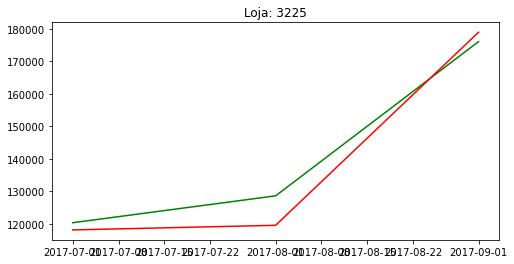

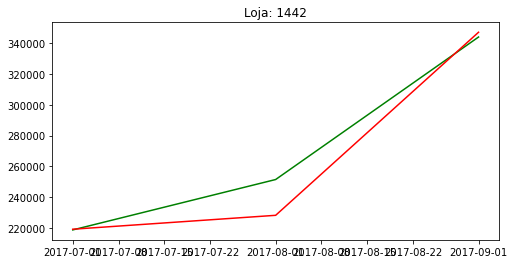

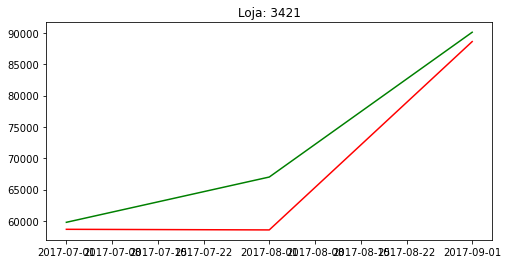

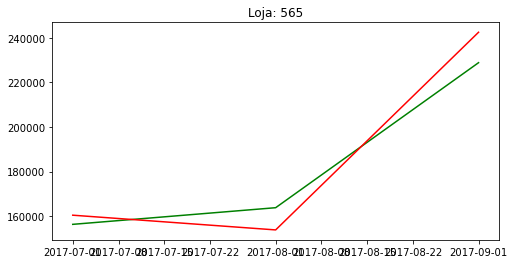

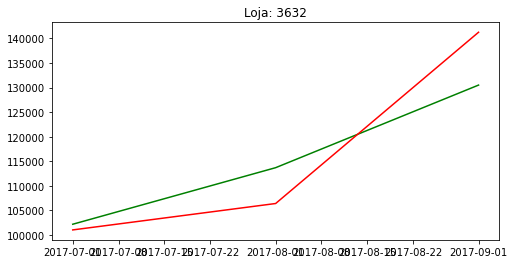

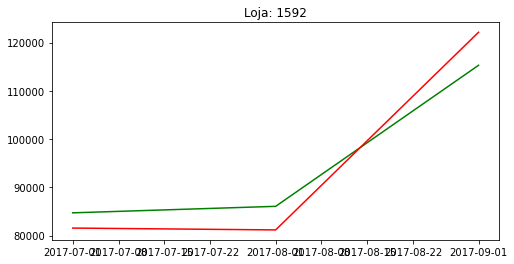

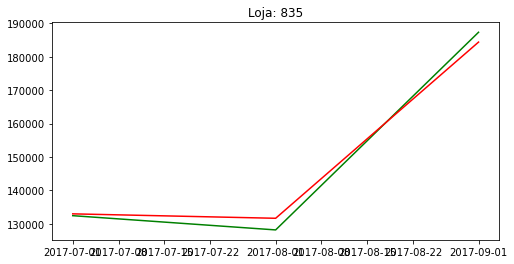

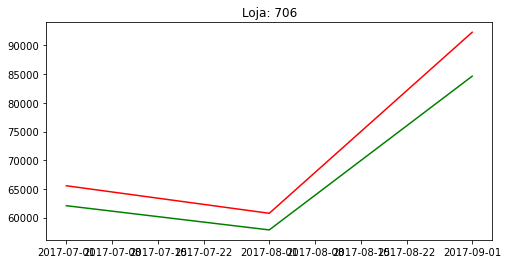

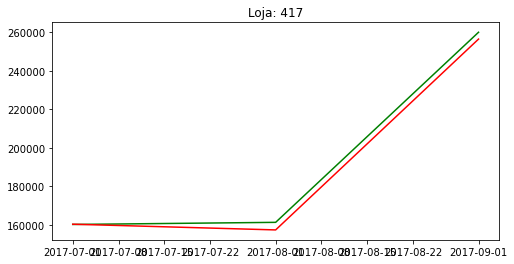

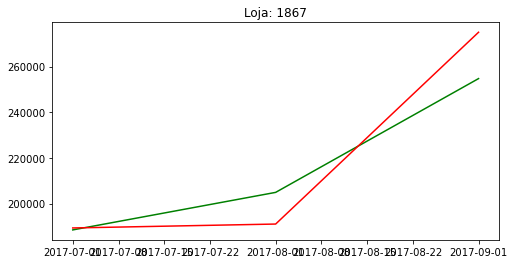

In [52]:
i = 0
while (i < 10):
    cod_loja = random.choice(df_preds['cod_loja'].unique())
    data_plot = df_preds.loc[df_preds['cod_loja'] == cod_loja]
    if (len(data_plot) > 0):
        plt.figure(figsize=(8,4))
        plt.plot(data_plot['ano_mes'], data_plot['true'], color='green', label='True')
        plt.plot(data_plot['ano_mes'], data_plot['pred'], color='red', label='Pred')
        plt.title(f'Loja: {cod_loja}')
        plt.show()
        i+=1